In [2]:
# %% [1] IMPORT & SETUP
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from wordcloud import WordCloud
import joblib

RAW_PATH = "nyarigawe_reviews.csv"                 # opsional (untuk demo before-after)
CLEAN_PATH = "nyarigawe_reviews_clean.csv"         # utama untuk training
MODEL_PATH = "svm_sentiment_model.joblib"

print("OK: import selesai")

OK: import selesai


In [3]:
# %% [2] LOAD DATA (UTAMA: CLEAN)
if not os.path.exists(CLEAN_PATH):
    raise FileNotFoundError(f"{CLEAN_PATH} tidak ditemukan. Taruh file di folder yang sama dengan notebook/script.")

df_clean = pd.read_csv(CLEAN_PATH)
print("CLEAN shape:", df_clean.shape)
print("Kolom:", df_clean.columns.tolist())

# wajib ada kolom text & label
if "text" not in df_clean.columns or "label" not in df_clean.columns:
    raise ValueError("File clean harus punya kolom: text dan label")

df_clean["text"] = df_clean["text"].astype(str)
df_clean["label"] = df_clean["label"].astype(int)

print("\nDistribusi label:")
print(df_clean["label"].value_counts())

display(df_clean.head())

CLEAN shape: (640, 3)
Kolom: ['text', 'label', 'score']

Distribusi label:
label
0    432
1    208
Name: count, dtype: int64


,text,label,score
0,kode otp gmail padahal gmail benar anehh,0,1
1,otp kirim padahal email bener,0,1
2,burik gubernur jelas masa kode otp,0,1
3,jelek daftar susah kayak cari kerja daftar mudah,0,1
4,mah nyari gawe susah bikin susah dapetin kode ...,0,1


In [4]:
# %% [3] PREPROCESSING DEMO (BEFORE -> AFTER) | OPSIONAL UNTUK LAPORAN
STOPWORDS_FALLBACK = {
    "yang","dan","di","ke","dari","ini","itu","ada","atau","untuk","dengan","pada","saya","aku",
    "kamu","dia","mereka","kami","kita","nya","lah","kok","sih","nih","ya","iya","aja","deh",
    "dong","min","admin","aplikasi","app","ga","gak","nggak","tdk","tidak","bukan","udah",
    "sudah","belum","bgt","banget","bisa","dapat","dapet","kalo","kalau","karena","jadi",
    "sebagai","juga","lagi","lg","pun","akan","lebih","masih","sangat","harus","mau"
}

HAS_SASTRAWI = False
stemmer = None
stopwords = set(STOPWORDS_FALLBACK)

try:
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

    stop_factory = StopWordRemoverFactory()
    stopwords = set(stop_factory.get_stop_words()) | set(STOPWORDS_FALLBACK)

    stem_factory = StemmerFactory()
    stemmer = stem_factory.create_stemmer()
    HAS_SASTRAWI = True
except Exception:
    HAS_SASTRAWI = False

print("Pakai Sastrawi:", HAS_SASTRAWI)

def basic_clean(text: str) -> str:
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = text.replace("\n", " ").replace("\t", " ")
    text = re.sub(r"http\S+|www\.\S+", " ", text)   # hapus url
    text = re.sub(r"\S+@\S+", " ", text)           # hapus email
    text = re.sub(r"[^a-z\s]", " ", text)          # sisakan huruf & spasi (hapus angka, emoji, tanda baca)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_stopwords(text: str) -> str:
    if not text:
        return ""
    tokens = [t for t in text.split() if t not in stopwords and len(t) > 1]
    return " ".join(tokens)

def do_stemming(text: str) -> str:
    if not text or stemmer is None:
        return text
    return stemmer.stem(text)

def clean_pipeline(text: str) -> str:
    text = basic_clean(text)
    text = remove_stopwords(text)
    text = do_stemming(text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

if os.path.exists(RAW_PATH):
    df_raw = pd.read_csv(RAW_PATH)
    if "content" in df_raw.columns:
        demo = df_raw[["content"]].dropna().head(10).copy()
        demo["after_cleaning"] = demo["content"].apply(clean_pipeline)
        display(demo)
    else:
        print("RAW ada, tapi kolom 'content' tidak ditemukan. Skip demo before-after.")
else:
    print("RAW file tidak ada. Skip demo before-after (tidak masalah, modeling tetap bisa).")


Pakai Sastrawi: True


,content,after_cleaning
0,tidak dapat kode OTP ke gmail.padahal gmail su...,kode otp gmail padahal gmail benar anehh
1,"otp gak dikirim, padahal email bener",otp kirim padahal email bener
2,burik banget aplikasi ini gubernur gak jelas m...,burik gubernur jelas masa kode otp
3,"Aplikasi jelek, mau daftar susah, gak kayak ap...",jelek daftar susah kayak cari kerja daftar mudah
4,udah mah nyari gawe susah di bikin susah lg da...,mah nyari gawe susah bikin susah dapetin kode ...
5,tolong lah kasih pemahaman ke perusahaan perus...,kasih paham usaha usaha bikin lowong ilangin n...
6,"min saya kencet batal lamar, apakah saya bisa ...",kencet batal lamar lamar usaha batal
7,beberapa bagian ada yang nggak bisa diedit. pa...,beberapa bagi edit pas save tulis error trus k...
8,"ijin min, kenapa saya ga ada notif verivikasi ...",ijin notif verivikasi email pas buat akun pada...
9,kelanjutan lamaran sudah 1 bulan tidak di ketahui,lanjut lamar bulan tahu


In [5]:
# %% [4] TRAIN-TEST SPLIT (PAKAI DATA CLEAN)
X = df_clean["text"]
y = df_clean["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Distribusi train:", pd.Series(y_train).value_counts().to_dict())
print("Distribusi test :", pd.Series(y_test).value_counts().to_dict())


Train: (512,) Test: (128,)
Distribusi train: {0: 346, 1: 166}
Distribusi test : {0: 86, 1: 42}


Accuracy (Linear): 0.8203125

Classification Report (Linear):
              precision    recall  f1-score   support

           0     0.8058    0.9651    0.8783        86
           1     0.8800    0.5238    0.6567        42

    accuracy                         0.8203       128
   macro avg     0.8429    0.7445    0.7675       128
weighted avg     0.8302    0.8203    0.8056       128

Confusion Matrix (Linear):
 [[83  3]
 [20 22]]


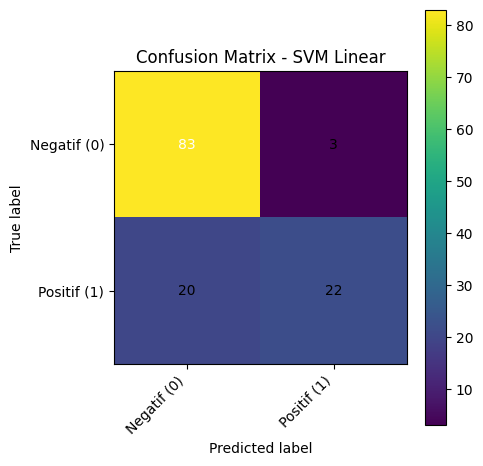

In [6]:
# %% [5] SVM LINEAR + EVALUASI
svm_linear = make_pipeline(
    TfidfVectorizer(),
    SVC(kernel="linear")
)

svm_linear.fit(X_train, y_train)
pred_linear = svm_linear.predict(X_test)

acc_linear = accuracy_score(y_test, pred_linear)
print("Accuracy (Linear):", acc_linear)
print("\nClassification Report (Linear):")
print(classification_report(y_test, pred_linear, digits=4))

cm_linear = confusion_matrix(y_test, pred_linear)
print("Confusion Matrix (Linear):\n", cm_linear)

def plot_confusion(cm, title):
    labels = ["Negatif (0)", "Positif (1)"]
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick = np.arange(len(labels))
    plt.xticks(tick, labels, rotation=45, ha="right")
    plt.yticks(tick, labels)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]}",
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion(cm_linear, "Confusion Matrix - SVM Linear")


Accuracy (RBF): 0.796875

Classification Report (RBF):
              precision    recall  f1-score   support

           0     0.7727    0.9884    0.8673        86
           1     0.9444    0.4048    0.5667        42

    accuracy                         0.7969       128
   macro avg     0.8586    0.6966    0.7170       128
weighted avg     0.8291    0.7969    0.7687       128

Confusion Matrix (RBF):
 [[85  1]
 [25 17]]


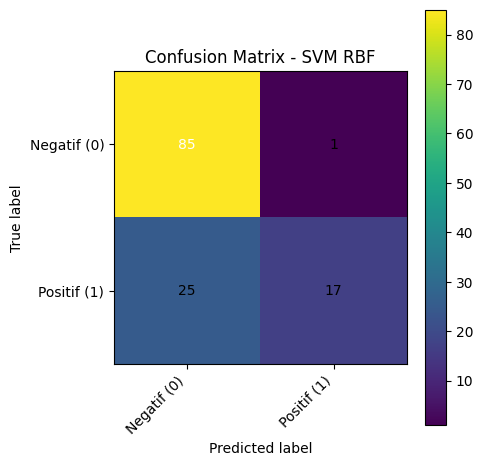

In [7]:
# %% [6] SVM RBF + EVALUASI
svm_rbf = make_pipeline(
    TfidfVectorizer(),
    SVC(kernel="rbf")
)

svm_rbf.fit(X_train, y_train)
pred_rbf = svm_rbf.predict(X_test)

acc_rbf = accuracy_score(y_test, pred_rbf)
print("Accuracy (RBF):", acc_rbf)
print("\nClassification Report (RBF):")
print(classification_report(y_test, pred_rbf, digits=4))

cm_rbf = confusion_matrix(y_test, pred_rbf)
print("Confusion Matrix (RBF):\n", cm_rbf)
plot_confusion(cm_rbf, "Confusion Matrix - SVM RBF")


In [8]:
# %% [7] ANALISIS ERROR (CONTOH SALAH PREDIKSI)
def show_misclassified(X_test, y_true, y_pred, n=10):
    idx = np.where(y_true.values != y_pred)[0]
    print("Jumlah salah prediksi:", len(idx))
    for k, i in enumerate(idx[:n], 1):
        print("-" * 70)
        print(f"{k}. TRUE={y_true.values[i]} | PRED={y_pred[i]}")
        print(X_test.values[i])

print("=== Misclassified (Linear) ===")
show_misclassified(X_test, y_test, pred_linear, n=10)

print("\n=== Misclassified (RBF) ===")
show_misclassified(X_test, y_test, pred_rbf, n=10)


=== Misclassified (Linear) ===
Jumlah salah prediksi: 23
----------------------------------------------------------------------
1. TRUE=1 | PRED=0
hrd bodoh punya skill takut naruh lowong sini
----------------------------------------------------------------------
2. TRUE=1 | PRED=0
apknya ribet kaya apk tampil mudah erti tampil bagus minus lamar panggil hehehe
----------------------------------------------------------------------
3. TRUE=1 | PRED=0
baik sistem login masa tiap buka login ulang
----------------------------------------------------------------------
4. TRUE=1 | PRED=0
bagus effisiensi development bom sempurna data usaha bom semua masuk otp kasih opsi gmail nomer hp wa free mudah mimin thanks os hp bawah kendala
----------------------------------------------------------------------
5. TRUE=1 | PRED=0
baik kategori alam kerja harus jngan wajib soal banyak orang kerja banyak punya surat terang kerja atau alam sama sekali baik
--------------------------------------------------

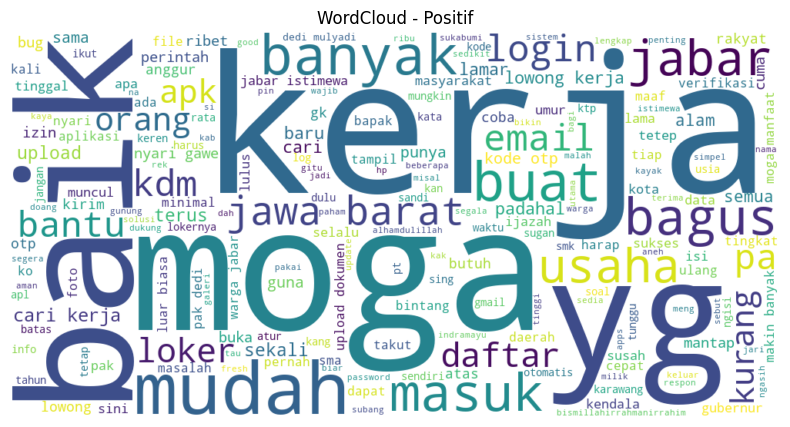

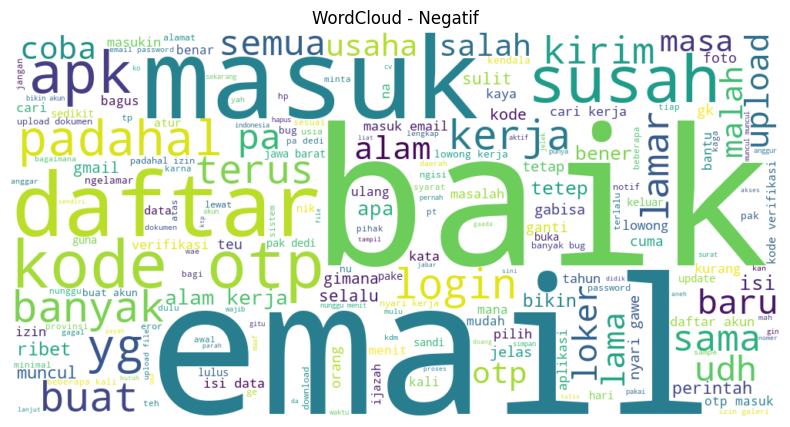

In [9]:
# %% [8] WORDCLOUD (WAJIB)
pos_text = " ".join(df_clean.loc[df_clean["label"] == 1, "text"].astype(str).tolist())
neg_text = " ".join(df_clean.loc[df_clean["label"] == 0, "text"].astype(str).tolist())

def show_wordcloud(text, title):
    wc = WordCloud(width=1000, height=500, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

show_wordcloud(pos_text, "WordCloud - Positif")
show_wordcloud(neg_text, "WordCloud - Negatif")


In [10]:
# %% [9] TUNING SEDERHANA (C / GAMMA)
pipe_linear = make_pipeline(TfidfVectorizer(), SVC(kernel="linear"))
grid_linear = {"svc__C": [0.1, 1, 3, 10]}

gs_linear = GridSearchCV(pipe_linear, grid_linear, cv=5, n_jobs=-1)
gs_linear.fit(X_train, y_train)
best_linear = gs_linear.best_estimator_
pred_best_linear = best_linear.predict(X_test)
acc_best_linear = accuracy_score(y_test, pred_best_linear)

print("Best Linear Params:", gs_linear.best_params_)
print("Accuracy Best Linear:", acc_best_linear)

pipe_rbf = make_pipeline(TfidfVectorizer(), SVC(kernel="rbf"))
grid_rbf = {"svc__C": [0.3, 1, 3, 10], "svc__gamma": ["scale", 0.1, 0.01]}

gs_rbf = GridSearchCV(pipe_rbf, grid_rbf, cv=5, n_jobs=-1)
gs_rbf.fit(X_train, y_train)
best_rbf = gs_rbf.best_estimator_
pred_best_rbf = best_rbf.predict(X_test)
acc_best_rbf = accuracy_score(y_test, pred_best_rbf)

print("Best RBF Params:", gs_rbf.best_params_)
print("Accuracy Best RBF:", acc_best_rbf)

Best Linear Params: {'svc__C': 1}
Accuracy Best Linear: 0.8203125
Best RBF Params: {'svc__C': 3, 'svc__gamma': 'scale'}
Accuracy Best RBF: 0.796875


In [11]:
# %% [10] SIMPAN MODEL TERBAIK UNTUK STREAMLIT
candidates = [
    ("svm_linear", svm_linear, acc_linear),
    ("svm_rbf", svm_rbf, acc_rbf),
    ("best_linear", best_linear, acc_best_linear),
    ("best_rbf", best_rbf, acc_best_rbf),
]
candidates = sorted(candidates, key=lambda x: x[2], reverse=True)

best_name, best_model, best_acc = candidates[0]
print("Model terbaik:", best_name, "Acc:", best_acc)

joblib.dump(best_model, MODEL_PATH)
print("Model tersimpan:", MODEL_PATH)

# uji cepat
sample_texts = [
    "aplikasinya sangat membantu dan mudah digunakan",
    "sering error dan susah dipakai mengecewakan"
]
print("Prediksi contoh:", best_model.predict(sample_texts))

Model terbaik: svm_linear Acc: 0.8203125
Model tersimpan: svm_sentiment_model.joblib
Prediksi contoh: [1 0]
